# 7. 합성곱 신경망(CNN)

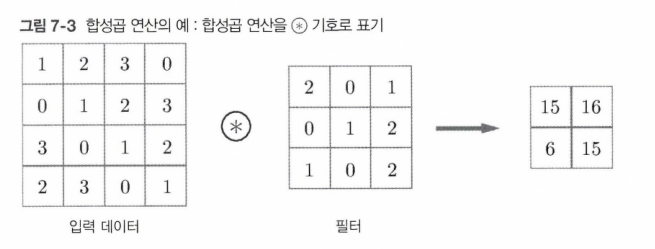

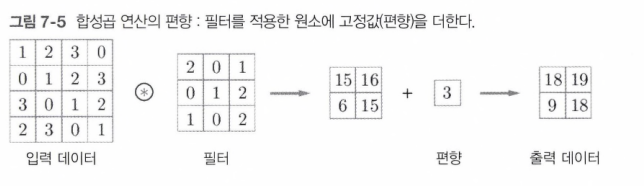

### 7.2.3 패딩
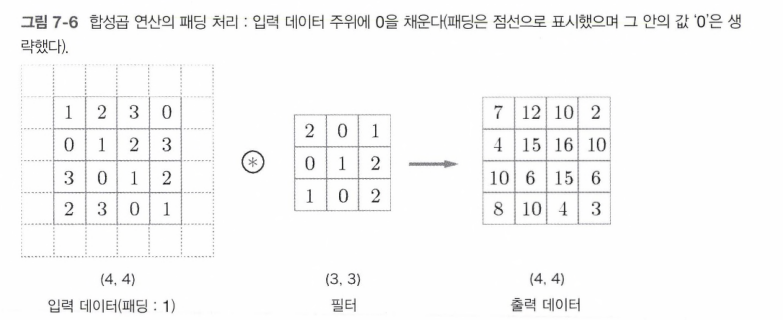

### 7.2.4 스트라이드
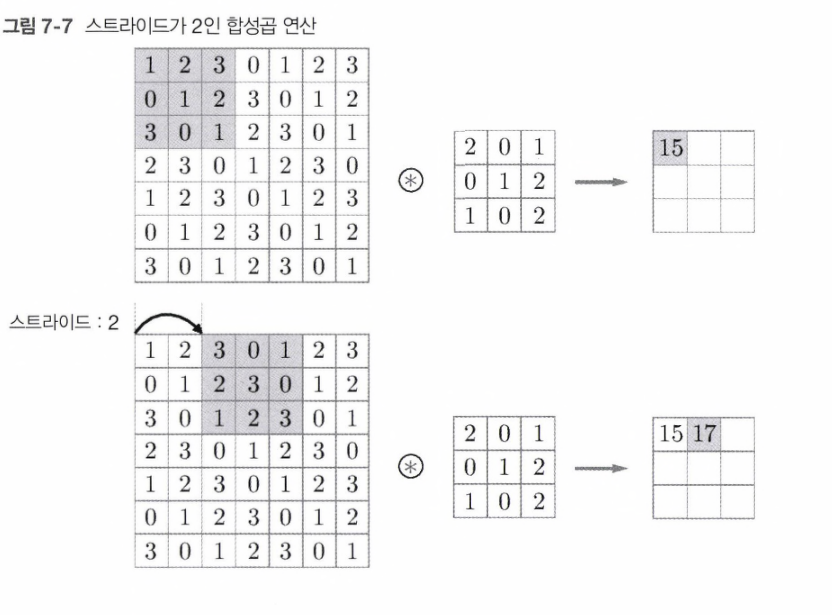

스트라이드를 키우면 출력 크기는 작아짐. 한편, 패딩을 크게 하면 출력 크기가 커짐

입력 크기를 (H, W), 필터 크기를 (FH, FW) 출력 크기를 (OH, 0W), 패딩을 P, 스트라이드를 S라 하면 클력 크기는 다음 식으로 계산함

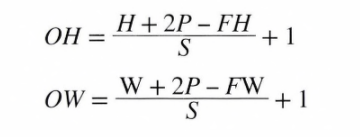

## 7.3 풀링계층
풀링계층의 특징
- 학습해야 할 매개변수가 없다
- 채널 수가 변하지 않는다

    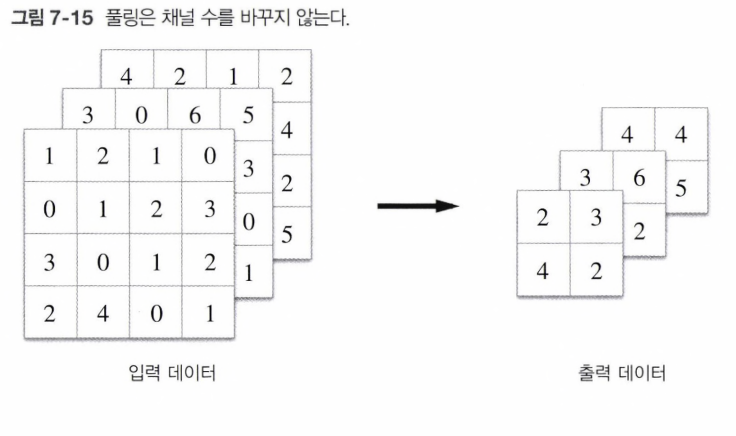
    
- 입력의 변화에 영향을 적게 받는다(강건하다)

    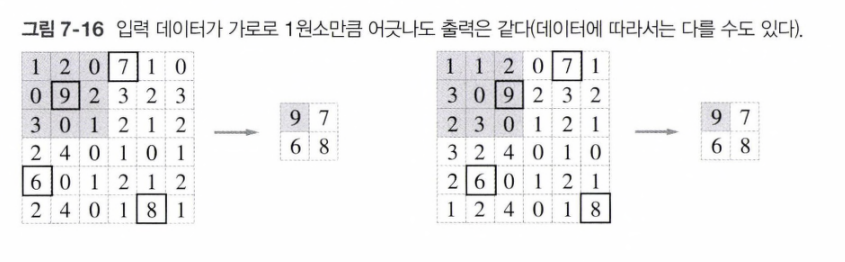

## 7.4 합성곱/풀링 계층 구현하기
합성곱 계층과 풀링 계층은 복잡해 보이지만, 사실 '트릭'을 사용하면 쉽게 구현할 수 있음.

이번 절에서는 그 트릭을 활용해 문제를 간단히 하면서 합성곱 계층을 구현해보겠음.

### 7.4.1 4차원 배열
CNN에서 계층 사이를 흐르는 데이터는 4차원이다. 

예를들어 데이터 형상이 (10, 1, 28, 28)이라면, 이는 높이 28, 너비 28. 채널 1개인 데이터가 10개라는 이야기.

In [7]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

10개 중 첫번째 데이터에 접근하려면 단순히 x[0]

첫번째 데이터의 첫 채널의 공간 데이터에 접근하려면 x[0, 0] or x[0][0]

In [10]:
x[0,0].shape

(28, 28)

### 7.4.2 im2col로 데이터 전개하기
합성곱 연산을 곧이곧대로 구현하려면 for 문을 겹겹이 쓰면 성능도 떨어지고 귀찮음 

-> 이번 절에서는 for문 대신 im2col이라는 편의함수를 이용해 간단하게 구현

ic2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개(펼치는)하는 함수

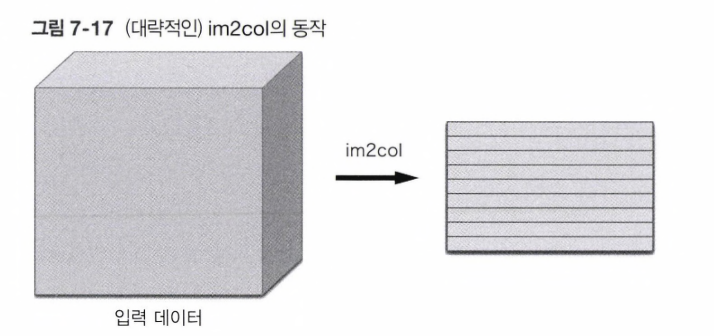 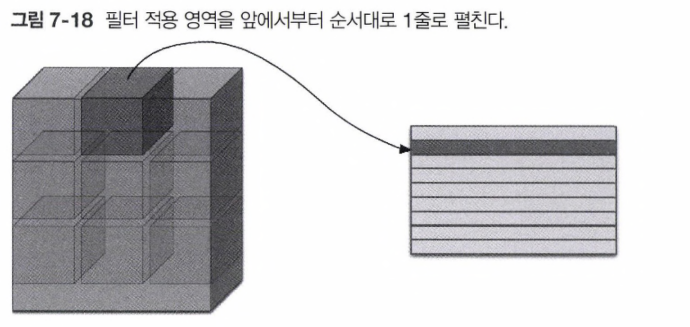

그림 7-18에서는 보기 좋게끔 스트라이드를 크게 잡아 필터의 적용 영역이 겹치지 않도록 했지만, 실제는 겹치는 경우가 대부분임. 

필터 적용 영역이 겹치게 되면 im2col로 전개한 후의 원소 수가 원래 블록의 원소 수보다 많아짐. 그래서 im2col을 사용해 구현하면 메모리를 더 많이 소비하는 단점이 있지만 컴퓨터는 큰 행렬을 묶어서 계산하는데 탁원함.

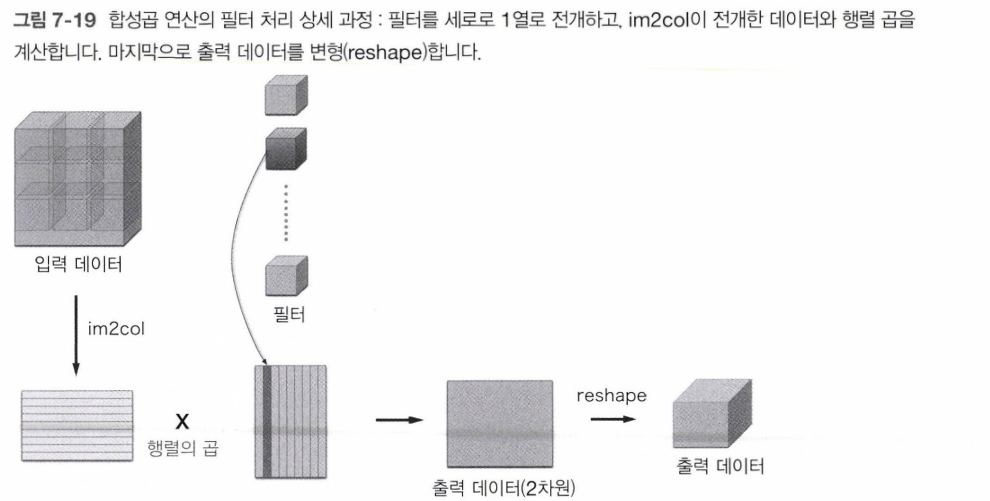

그림 7-19와 같이 im2col 방식으로 출력한 결과는 2차원 행렬임. CNN은 데이터를 차원 배열로 저장하므로 2차원인 출력 데이터를 4차원으로 reshape(변형)함.

### 7.4.3 합성곱 계층 구현하기

im2coi(input_data, filter_h, filter_w, stride=1, pad=0)
- input_data - （데이터 수, 채널 수, 높이, 너비）의 4차원 배열로 이뤄진 입력 데이터
- filter_h - 필터의 높이
- filter_w - 필터의 너비
- stride - 스트라이드
- pad - 패딩

In [11]:
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride =1, pad = 0) # (data수, 채널 수 , 높이, 너비)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride =1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


In [12]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad =0): 
        self.W = W # 필터(커널)의 가중치를 나타내는 배열. 크기는 (FN, C, FH, FW)
        self.b = b
        self.stride = stride
        self.pad = pad 

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FH) / self.stride)

        col = im2col(x , FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

### 7.4.4 풀링 계층 구현하기
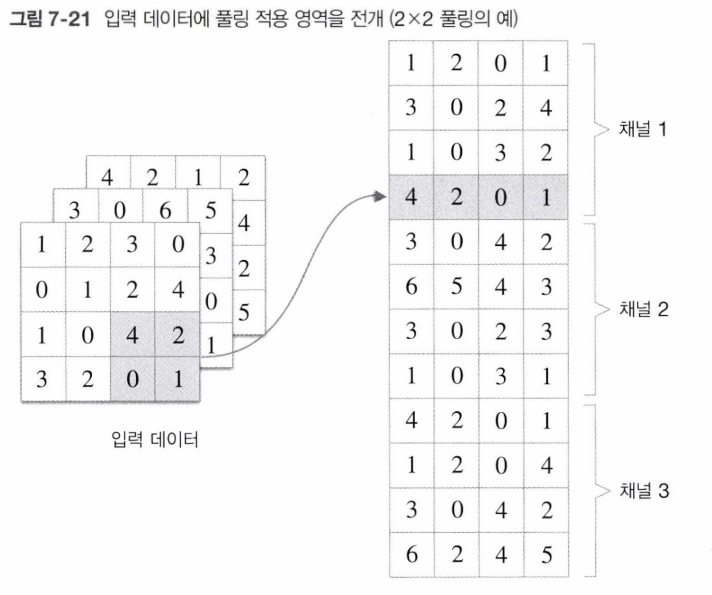

7-21 처럼 전개한 후 행별 최댓값을 추출

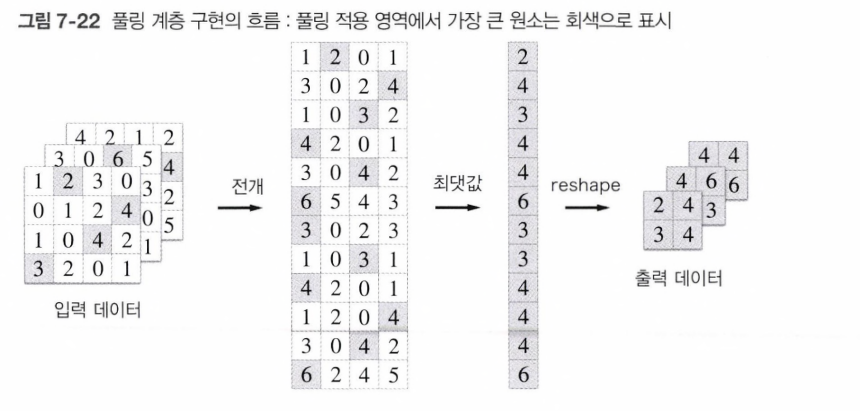



In [13]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis = 1)

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

## 7.5 CNN 구현하기
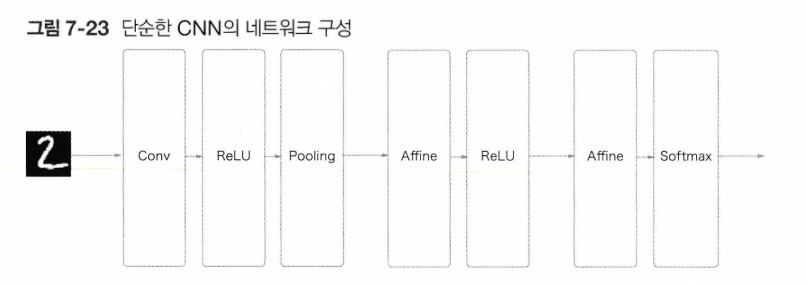

In [18]:
from collections import OrderedDict
from common.layers import *
class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28),
                 conv_param = {'filter_num': 30, 'filter_size': 5,
                               'pad': 0, 'stride': 1},
                               hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['filter_pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 *filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size /2))

        # 가중치 매개변수를 초기화하는 부분
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층들을 생성
        self.layers = OrderedDict()
        self.layers['Convl'] = Convolution(self.params['W1'],
                                            self.params['b1'],
                                            conv_param['stride'],
                                            conv_param['pad'])
        self.layers['Relul'] = Relu()
        self.layers [ 'Pooll' ] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affinel'] = Affine(self.params['W2'],
                                        self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
                                        self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affinel'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads